In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm import tqdm

os.chdir('/Users/theomoers/Documents/Columbia SIPA/Classes/Spring/Applying ML/ml-final-project/')
# plt.rcParams['text.usetex'] = True

In [19]:
actinvest = pd.read_csv('data/quarterly_actual_investment.csv', header=3)
socioecon = pd.read_csv('data/socioeconomics.csv', header=3)
manuf_meta = pd.read_csv('data/manufacturing_energy_and_industry_facility_metadata.csv', header=3)
fedinveststata = pd.read_csv('data/federal_actual_investment_by_state.csv', header=3)
fedinvestcat = pd.read_csv('data/federal_actual_investment_by_category.csv', header=3)
congress = pd.read_csv('data/congressional_district_actual_investment_manufacturing_energy_and_industry.csv', header=5)
merged = pd.read_csv('data/posteda/merged_posteda.csv')
doe = pd.read_csv('data/doe_invest.csv')

In [ ]:
meta = fedinveststata[['State', 'quarter', 'Total Federal Investment', 'Federal investment per capita', 'Population', 'State GDP (Annualized)']]
meta = meta.rename(columns={'State': 'state', 'Total Federal Investment': 'total_fed_investment', 'Federal investment per capita': 'fed_invest_per_capita', 'Population': 'population', 'State GDP (Annualized)': 'state_gdp'})
socioecon = socioecon.rename(columns={'State': 'state', 'Population': 'population'})
meta = meta.merge(socioecon, on=['state', 'quarter'], how='left')
meta = meta.drop(columns=['population_y'])
meta = meta.rename(columns={'population_x': 'population'})

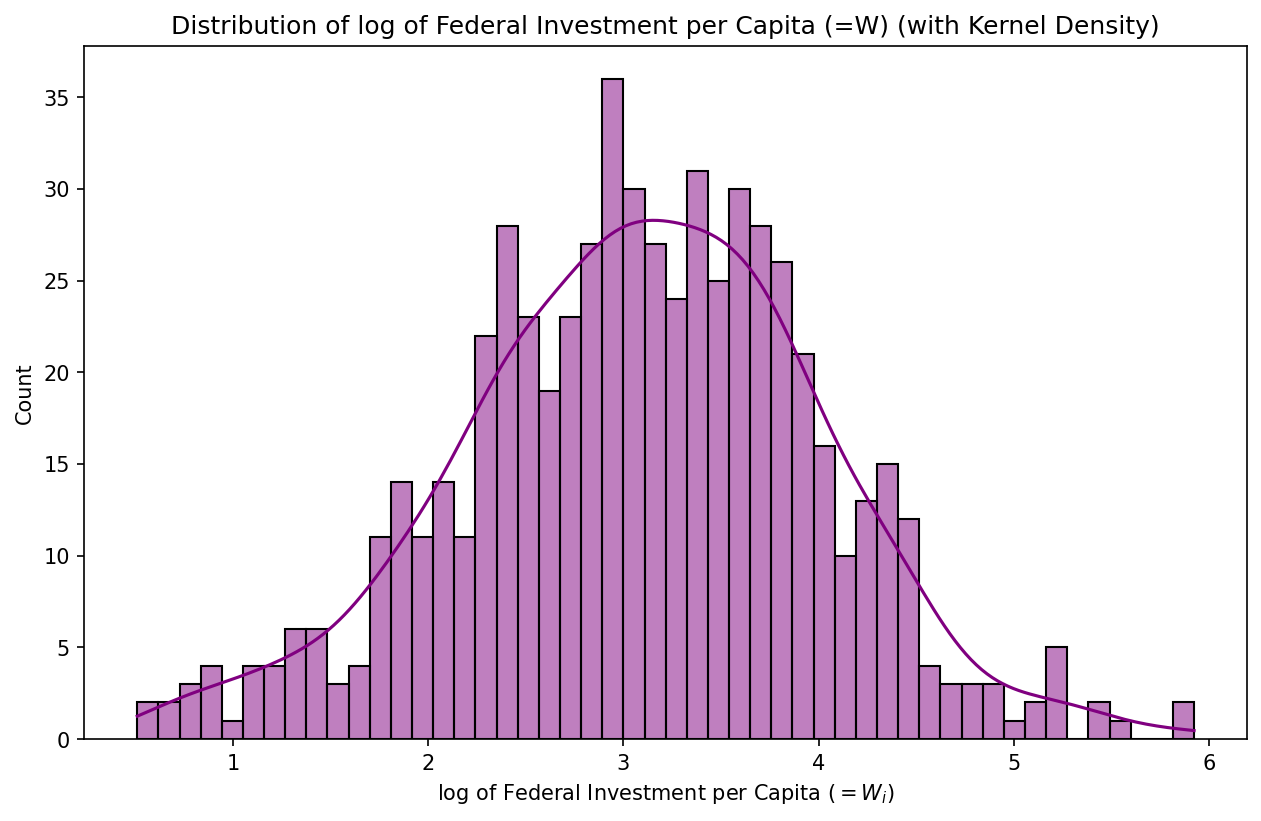

In [ ]:
# log transform per capita federal investment and plot
meta['log_fed_invest_per_capita'] = np.log(meta['fed_invest_per_capita'] + 1)
plt.figure(figsize=(10, 6))
sns.histplot(meta['log_fed_invest_per_capita'], bins=50, kde=True, color='purple', alpha=0.5)
plt.title('Distribution of log of Federal Investment per Capita (=W) (with Kernel Density)')
plt.xlabel(r'log of Federal Investment per Capita $(=W_i)$')
plt.show()

In [ ]:
summed_con = congress.groupby(['State', 'quarter'])['Estimated_Actual_Quarterly_Expenditure'].sum().reset_index()
summed_con = summed_con.rename(columns={
    'Estimated_Actual_Quarterly_Expenditure': 'actual_quarterly_expenditure', 
    'State': 'state',})

meta = meta.merge(summed_con, on=['state', 'quarter'], how='left')

meta['actual_quarterly_expenditure_per_capita'] = meta['actual_quarterly_expenditure'] / meta['population']
meta['actual_quarterly_expenditure_per_capita_per100k'] = meta['actual_quarterly_expenditure_per_capita'] * 100000

meta['log_actual_quarterly_expenditure_per_capita_per100k'] = np.log1p(meta['actual_quarterly_expenditure_per_capita_per100k'])

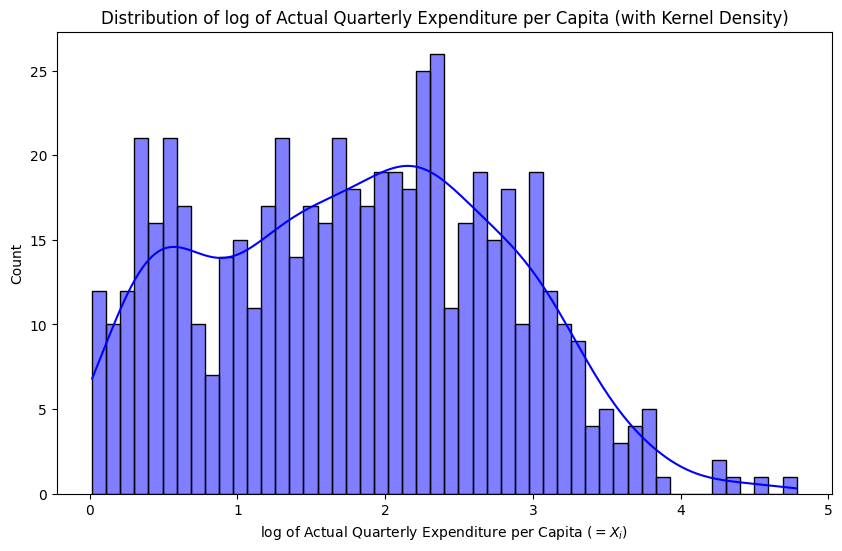

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(meta['log_actual_quarterly_expenditure_per_capita_per100k'], bins=50, kde=True, color='blue', alpha=0.5)
plt.title('Distribution of log of Actual Quarterly Expenditure per Capita (with Kernel Density)')
plt.xlabel(r'log of Actual Quarterly Expenditure per Capita $(=X_i)$')
plt.show()

# Political Dominance

In [ ]:
def _compute_house_share(congress):
    house = (
        congress[
            ['State', 'quarter', 'CD119_2024_Name', 'US Representative Party']
        ]
        .drop_duplicates()
    )
    agg = (
        house
        .groupby(['State','quarter'])['US Representative Party']
        .agg(
            total_house_seats='size',
            dem_house_seats=lambda x: (x=='Democratic').sum()
        )
        .reset_index()
    )
    agg['dem_house_share'] = (
        agg['dem_house_seats'] / agg['total_house_seats']
    )
    return agg[['State','quarter','dem_house_share']]


def _compute_senate_share(congress):
    senate = (
        congress[
            ['State','quarter','US Senator 1: Party','US Senator 2: Party']
        ]
        .drop_duplicates()
    )
    senate['dem_senate_seats'] = (
        (senate['US Senator 1: Party']=='Democratic').astype(int)
      + (senate['US Senator 2: Party']=='Democratic').astype(int)
    )
    agg = (
        senate
        .groupby(['State','quarter'])['dem_senate_seats']
        .max()
        .reset_index()
    )
    agg['dem_senate_share'] = agg['dem_senate_seats'] / 2
    return agg[['State','quarter','dem_senate_share']]


def add_political_dominance(congress, theta=0.5):
    hs = _compute_house_share(congress)
    ss = _compute_senate_share(congress)

    # Merge back to every segment‐level row
    df = congress.merge(hs, on=['State','quarter'], how='left')
    df = df.merge(ss, on=['State','quarter'], how='left')
    df = df.rename(columns={'State': 'state'})

    df['political_dominance'] = (
        theta * df['dem_house_share'] 
        + (1 - theta) * df['dem_senate_share']
    )
    return df

new_con = add_political_dominance(congress, 0.6)

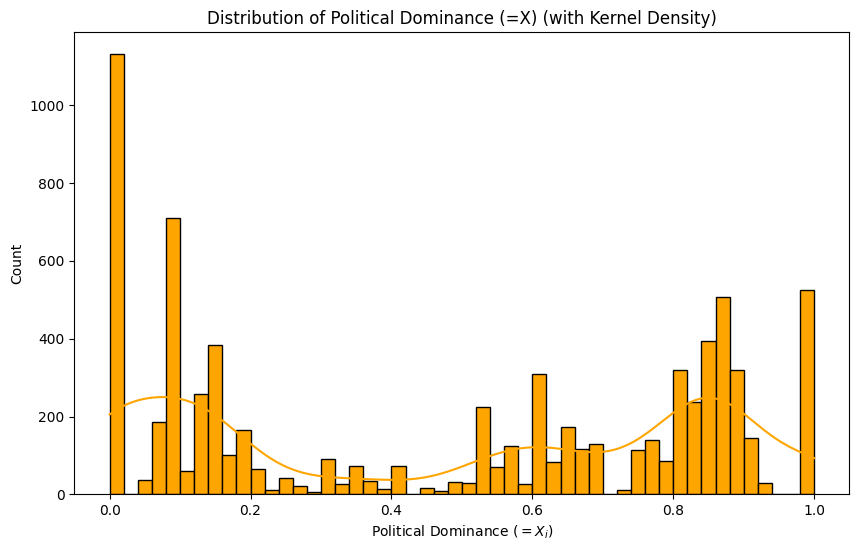

In [26]:
# histogram of political_dominance
plt.figure(figsize=(10, 6))
sns.histplot(new_con['political_dominance'], bins=50, kde=True, color='orange', alpha=1)
plt.xlabel(r'Political Dominance $(=X_i)$')
plt.title('Distribution of Political Dominance (=X) (with Kernel Density)')
plt.show()

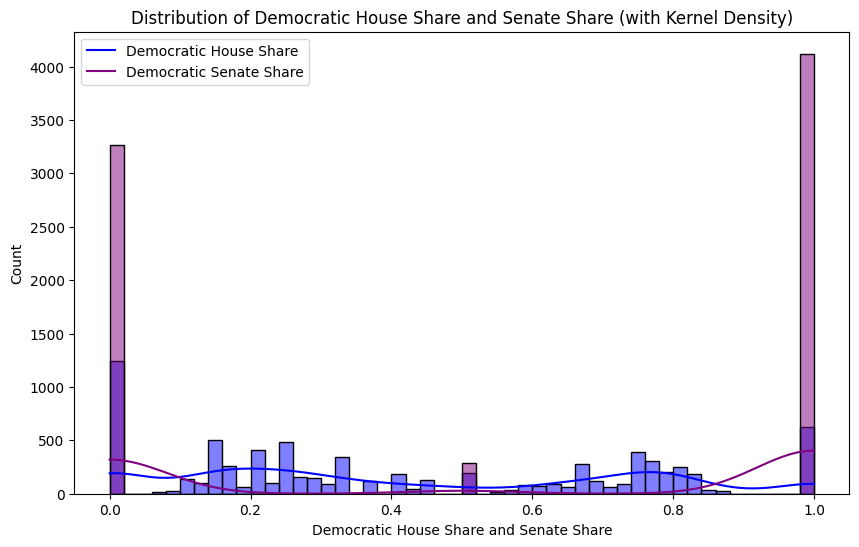

In [27]:
# hist of dem_house_share and dem_senate_share
plt.figure(figsize=(10, 6))
sns.histplot(new_con['dem_house_share'], bins=50, kde=True, color='blue', alpha=0.5)
sns.histplot(new_con['dem_senate_share'], bins=50, kde=True, color='purple', alpha=0.5)
plt.xlabel(r'Democratic House Share and Senate Share')
plt.title('Distribution of Democratic House Share and Senate Share (with Kernel Density)')
plt.legend(['Democratic House Share', 'Democratic Senate Share'])
plt.show()